# Imports, Data Cleaning, File Management

In [1]:
# General Imports
import numpy as np
import pandas as pd
from pathlib import Path
from varname import argname2
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Time Series
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model

# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# LSTM
from numpy.random import seed
from tensorflow import random
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# SVM

%matplotlib inline

In [2]:
# Read & Clean Data Function

def getCSV(input_file):
    df = pd.read_csv(
        Path(input_file),
        index_col="Date",
        infer_datetime_format=True,
        parse_dates=True)
    df.drop(columns=['Volume'], inplace=True)
    df.dropna(inplace=True)
    return df

In [3]:
getCSV('AUDUSD.csv')

,Open,High,Low,Close,Adj Close
Date,,,,,
2006-05-16,0.762835,0.768994,0.760688,0.767106,0.767106
2006-05-17,0.766871,0.772618,0.757576,0.759417,0.759417
2006-05-18,0.759417,0.767577,0.758725,0.764000,0.764000
2006-05-19,0.763884,0.764818,0.753012,0.757174,0.757174
2006-05-22,0.756888,0.756888,0.747105,0.753409,0.753409
...,...,...,...,...,...
2021-07-21,0.733900,0.736030,0.728980,0.733891,0.733891
2021-07-22,0.735202,0.739700,0.734310,0.735262,0.735262
2021-07-23,0.738250,0.739200,0.735790,0.738050,0.738050


In [4]:
file = 'AUDUSD.csv'
forex = ['AUDUSD.csv']
comm = []
stocks = []
crypto = []

# Predictions

## 1 Time Series

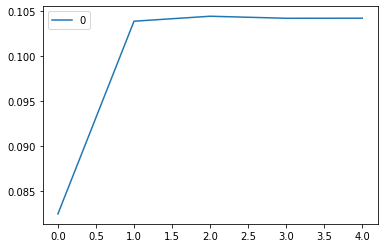

In [5]:
def time_series(file):
    df = getCSV(file)
    noise, trend = sm.tsa.filters.hpfilter(df['Close'])
    df2 = pd.DataFrame(df['Close'])
    df2['Noise'] = noise
    df2['Trend'] = trend
    returns = (df2[['Close']].pct_change() * 100)
    returns = returns.replace(-np.inf, np.nan).dropna()
    model = ARMA(returns['Close'].values, order=(2, 1))
    results = model.fit()
    pd.DataFrame(results.forecast(steps = 5)[0]).plot()
time_series(file)

## 2 Linear Regression

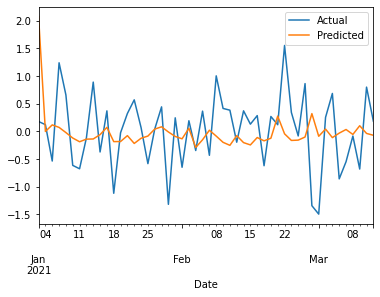

In [6]:
def linear_regression(file):
    df = getCSV(file)
    df['Return'] = (df[['Close']].pct_change() * 100)
    df = df.replace(-np.inf, np.nan).dropna()
    df['Lagged Return'] = df['Return'].shift()
    df = df.dropna()
    train = df[:'2020']
    test = df['2021':]
    X_train = train.drop(columns=['Lagged Return', 'Return'])
    X_test = test.drop(columns=['Lagged Return', 'Return'])
    y_train = train['Return']
    y_test = test['Return']
    model = LinearRegression()
    model.fit(X_train, y_train)
    pred_y = model.predict(X_test)
    actual = pd.DataFrame({'Actual' : y_test, 'Predicted': pred_y})
    actual.head(50).plot()
linear_regression(file)

## 3 LSTM

In [7]:
df = getCSV('AUDUSD.csv')

In [8]:
# TRY DIFFERENT ACTIVATION FUNCTIONS AND OPTIMIZERS

def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [9]:
window_size = 3

feature_column = 4
target_column = 4
X, y = window_data(df, 3, 4, 4)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[0.767106 0.759417 0.764   ]
 [0.759417 0.764    0.757174]
 [0.764    0.757174 0.753409]
 [0.757174 0.753409 0.750976]
 [0.753409 0.750976 0.753125]] 

y sample values:
[[0.757174]
 [0.753409]
 [0.750976]
 [0.753125]
 [0.760919]]


In [10]:
# Use 70% of the data for training and the remainder for testing
split = int(0.8 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [11]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.fit_transform(y_test)

In [12]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.04080548]
  [0.03886609]
  [0.04002205]]

 [[0.03886609]
  [0.04002205]
  [0.03830033]]

 [[0.04002205]
  [0.03830033]
  [0.03735069]]

 [[0.03830033]
  [0.03735069]
  [0.03673701]]

 [[0.03735069]
  [0.03673701]
  [0.03727906]]] 

X_test sample values:
[[[0.74331843]
  [0.73646117]
  [0.73012314]]

 [[0.73646117]
  [0.73012314]
  [0.73231191]]

 [[0.73012314]
  [0.73231191]
  [0.75889496]]

 [[0.73231191]
  [0.75889496]
  [0.74601747]]

 [[0.75889496]
  [0.74601747]
  [0.73800092]]]


In [13]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [14]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 3
dropout_fraction = 0.1

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [15]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [16]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 3)              60        
_________________________________________________________________
dropout (Dropout)            (None, 3, 3)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 3)              84        
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dropout_2 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4

In [17]:
# Train the model
model.fit(X_train, y_train, epochs=5, shuffle=False, batch_size=1, verbose=1)

Epoch 1/5
3144/3144 [==============================] - 6s 2ms/step - loss: 3.4542e-04
Epoch 2/5
3144/3144 [==============================] - 5s 2ms/step - loss: 3.3482e-04
Epoch 3/5
3144/3144 [==============================] - 5s 2ms/step - loss: 3.3737e-04
Epoch 4/5
3144/3144 [==============================] - 5s 1ms/step - loss: 3.3863e-04
Epoch 5/5
3144/3144 [==============================] - 5s 1ms/step - loss: 3.3895e-04


In [18]:
# Evaluate the model
model.evaluate(X_test, y_test)

25/25 [==============================] - 1s 983us/step - loss: 0.3708


0.3708333969116211

In [19]:
# Make some predictions
predicted = model.predict(X_test)

In [20]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [21]:
# Create a DataFrame of Real and Predicted values
forex = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
forex.head()

,Real,Predicted
Date,,
2018-06-22,0.737898,0.582722
2018-06-25,0.743837,0.582722
2018-06-26,0.740960,0.582722
2018-06-27,0.739169,0.582722
2018-06-28,0.734322,0.582722


<AxesSubplot:xlabel='Date'>

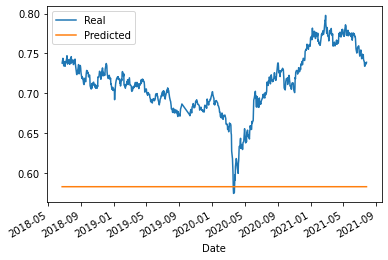

In [22]:
forex.plot()

## 4 SVM

In [23]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.svm import SVC

In [24]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker

In [25]:
def getSVM(file):
    df = getCSV(file)
    df['Return'] = (df[['Close']].pct_change() * 100)
    df = df.dropna()
    signals = []
    for i in df['Return']:
        if (i >= 0):
            signals.append(1)
        else:
            signals.append(0)
    df['Signal'] = signals
    
    X = df.drop(columns=['Return', 'Signal'])
    y = df['Signal']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    model = SVC(kernel='poly')
    
    model.fit(X_train, y_train)
    pred_y = model.predict(X_test)
    actual = pd.DataFrame({'Actual': y_test, 'Predicted': pred_y})
#     X_train = train.drop(columns=['Lagged Return', 'Return'])
#     X_test = test.drop(columns=['Lagged Return', 'Return'])
#     y_train = train['Return']
#     y_test = test['Return']
#     model = LinearRegression()
#     model.fit(X_train, y_train)
#     pred_y = model.predict(X_test)
#     actual = pd.DataFrame({'Actual' : y_test, 'Predicted': pred_y})
#     actual.head(50).plot()
    return actual
aud = getSVM('AUDUSD.csv')

<AxesSubplot:xlabel='Date'>

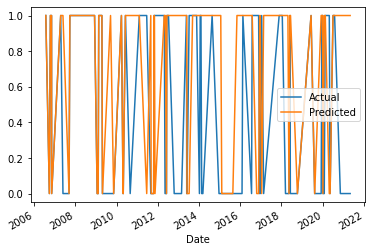

In [26]:
aud.head(100).plot()

# Exporting

In [27]:
# df.to_csv()